In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer


from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import classification_report, accuracy_score,  precision_score, recall_score, balanced_accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 1. Dataset Exploration
## a) Load the df_hackathon.csv dataset - (hint: use pandas)
Assign it to a variable called df.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving df_hackathon.csv to df_hackathon.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['df_hackathon.csv']))

## b) Using pandas examine the numerical features of the dataset

Examine the 7+1 figure summary (count, mean, std, min, 1Q, median, 3Q, max)

- Αre there any missing feature values?
- Are there any unexpected (or extreme) feature values?

Visualise in histograms the numerical features.

- Is there significant data skewness in any of the variables?

In [ ]:
#From the code given below, we can see that there are a lot of missing values in the hours_per_week column


#There are also a lot of enexpected/extreme values that can be seen as seen in the case of min(number_of_spells_mastered)
# -10000 cannot be a realistic value for this column and this is unexpected.
#There are also multiple people who have a negative numeber for the number of spells mastered. This is also unexpected

#We can see if there is any data skewness by looking at the graphs. The graphs show a negative skew for the age and
#number_of_spells_mastered


summary = df.describe()
print(summary)


               age  hours_per_week  magical_artifact_power_level  \
count  4931.000000     4091.000000                   4931.000000   
mean     38.669438       40.482034                  61805.427134   
std      13.507185       12.299278                  20997.789301   
min      17.000000        1.000000                  10825.600000   
25%      28.000000       40.000000                  45356.000000   
50%      37.000000       40.000000                  62720.400000   
75%      47.000000       45.000000                  79047.700000   
max      90.000000       99.000000                 105923.000000   

       number_of_spells_mastered  
count                4931.000000  
mean                   24.751572  
std                     8.759703  
min                    13.000000  
25%                    18.000000  
50%                    23.000000  
75%                    28.000000  
max                    45.000000  


age                               0
education                         0
marital_status                    0
occupation                        0
bloodline                         0
gender                            0
hours_per_week                  840
income_bracket                    0
magical_artifact_power_level      0
number_of_spells_mastered         0
gringotts_approved_loan           0
dtype: int64


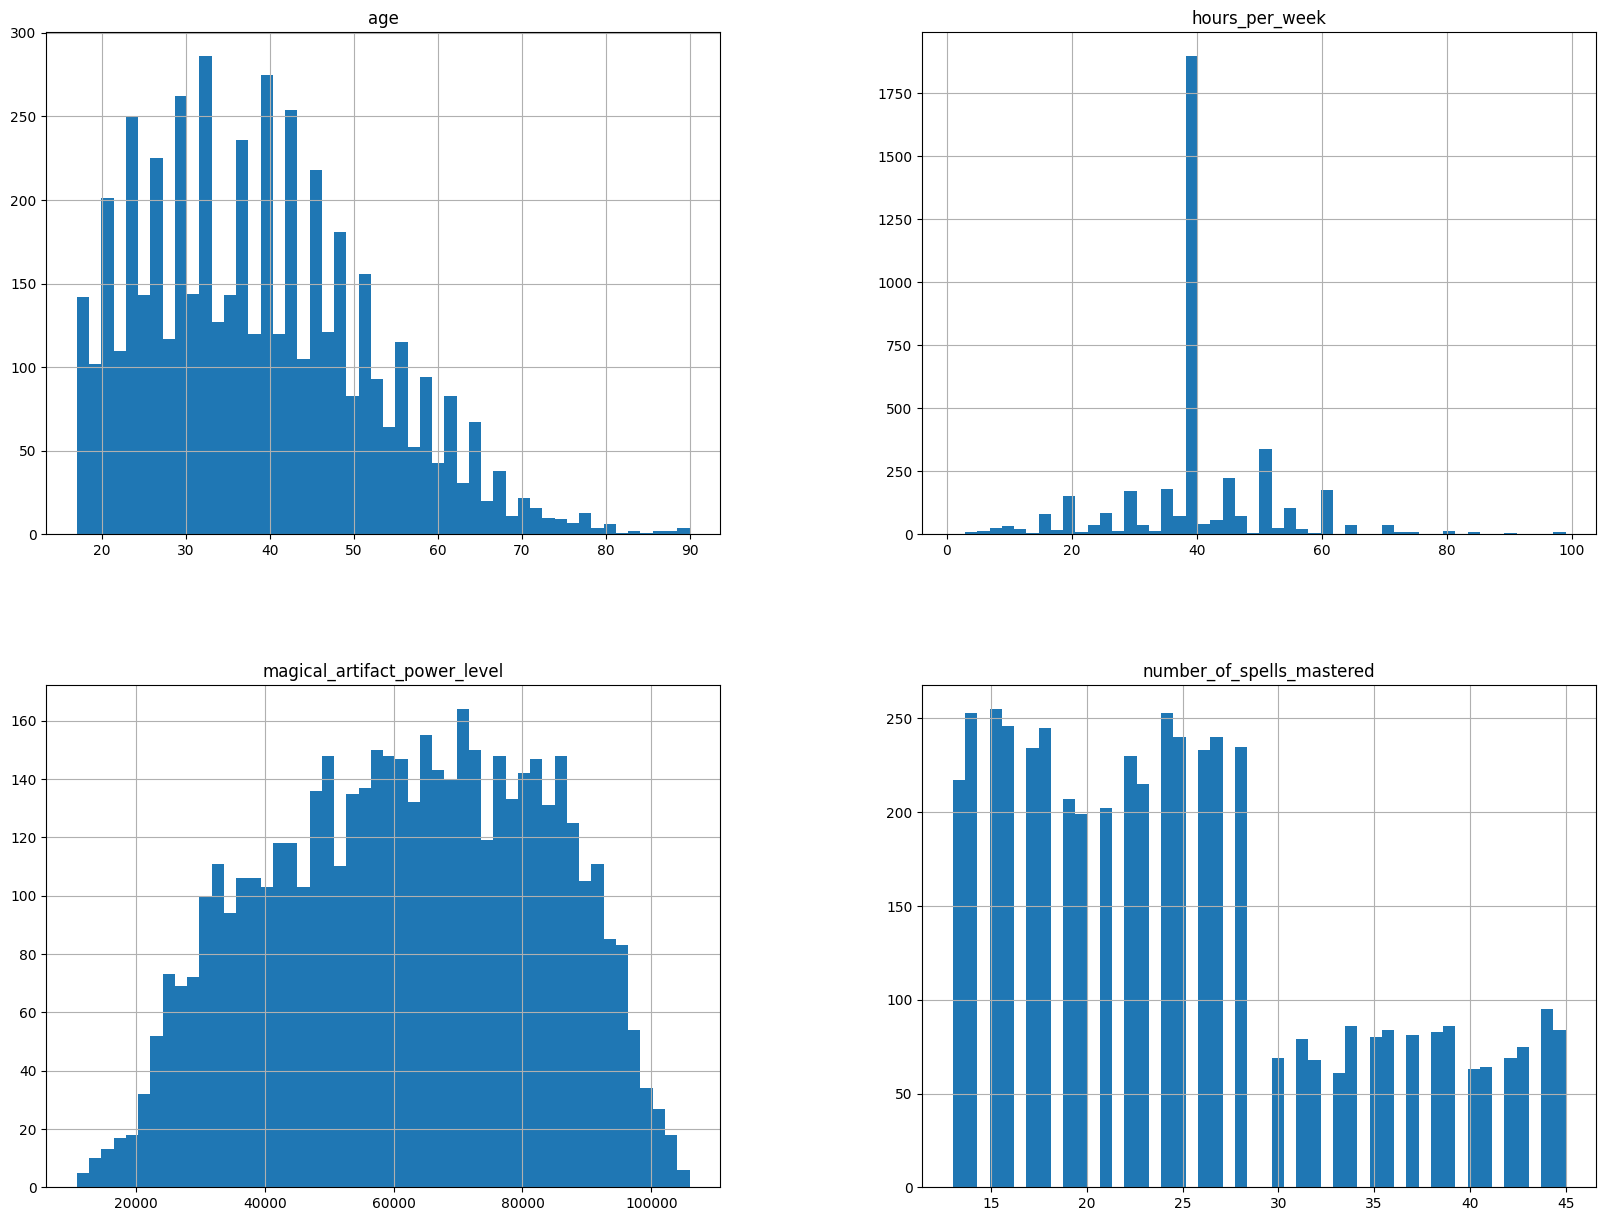

age                             0.562443
hours_per_week                  0.269085
magical_artifact_power_level   -0.138594
number_of_spells_mastered       0.699720
dtype: float64


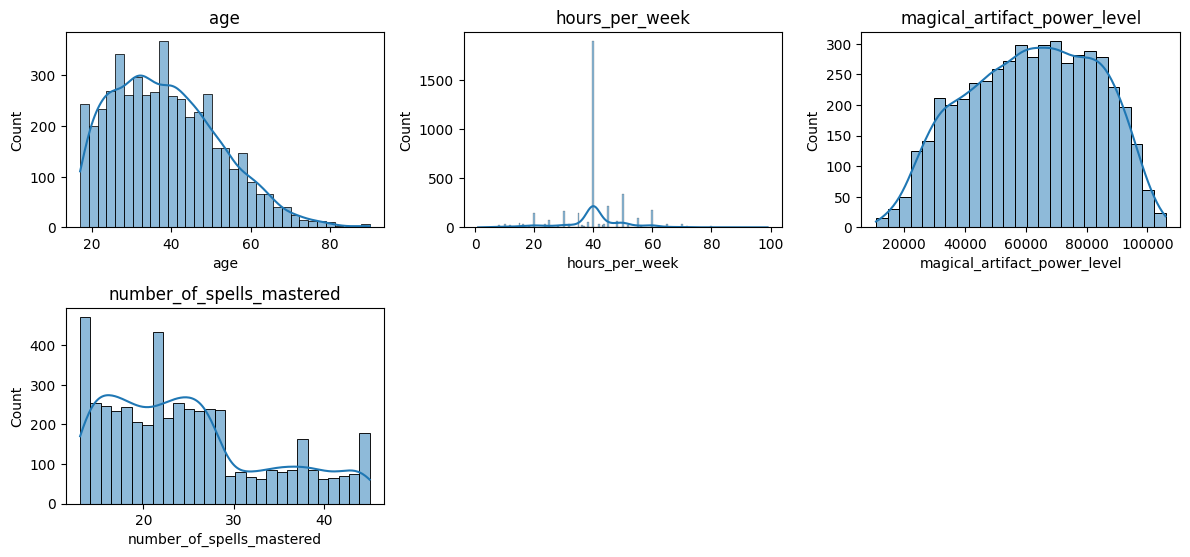

Skewness of numerical features:
age                             0.562443
hours_per_week                  0.269085
magical_artifact_power_level   -0.138594
number_of_spells_mastered       0.699720
dtype: float64


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Check for extreme values
numerical_columns = df.select_dtypes(include=['number']).columns
kurtosis_values = df[numerical_columns].kurtosis()

# Visualize the histograms
df[numerical_columns].hist(bins=50, figsize=(20, 15))
plt.show()

# Calculate skewness
skewness = df[numerical_columns].skew()
print(skewness)

numerical_features = df.select_dtypes(include=['int64', 'float64'])

# Plot histograms for numerical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_features.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Check for skewness
skewnes = numerical_features.skew()
print("Skewness of numerical features:")
print(skewnes)

## c) Using pandas examine the categorical features of the dataset

- Are there any significant inequalities in the dataset?
- Are there any features with missing values?

In [ ]:


# Identify categorical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Examine the value counts to check for significant inequalities
for col in categorical_cols:
    print(f"Value counts for {col}:\n{df[col].value_counts()}\n")

# Check for missing values in categorical features
missing_values = df[categorical_cols].isnull().sum()
print(f"Missing values in categorical features:\n{missing_values}")

Value counts for education:
Specialism in a magical field    1913
Hogwarts Graduate                1760
Aurors Specialism                 864
Dropout                           362
Charms Scholar                    101
Name: education, dtype: int64

Value counts for marital_status:
Married          2375
Never-married    1636
Divorced          675
Separated         164
Widowed           150
Name: marital_status, dtype: int64

Value counts for occupation:
Hogwarts Professor                741
Other                             682
Magical Shop Owner                620
Potioneer                         533
Wandmaker                         327
Gringotts Bank                    306
Magical Transportation            291
Auror                             279
Ministry of Magic Official        264
Wandlore Assistant                173
Potion Ingredients Supplier       170
Dark Forces Defense Consultant    160
Magical Intelligence Agent        156
Magical Librarian                 150
Goblin Liai

There are a significantly higher number of half bloods compared to other bloodlines.
No categorical features have missing values

## d) further dataset exploration
Using the facets library visualise the dataset (use code below). Try different combinations. Do you notice any patterns in the dataset that might influence the model's predictions?

In [ ]:
from IPython.core.display import display, HTML

vis_df = df.to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=vis_df)
display(HTML(html))

# 2. Feature Engineering

## a) Create a correlogram (hint: use pandas corr() function) and visualise it

- Are there any very strong correlations (numerical features)? if yes, remove one of the features.
- Explain how strong correlations can have an impact on some ML models.

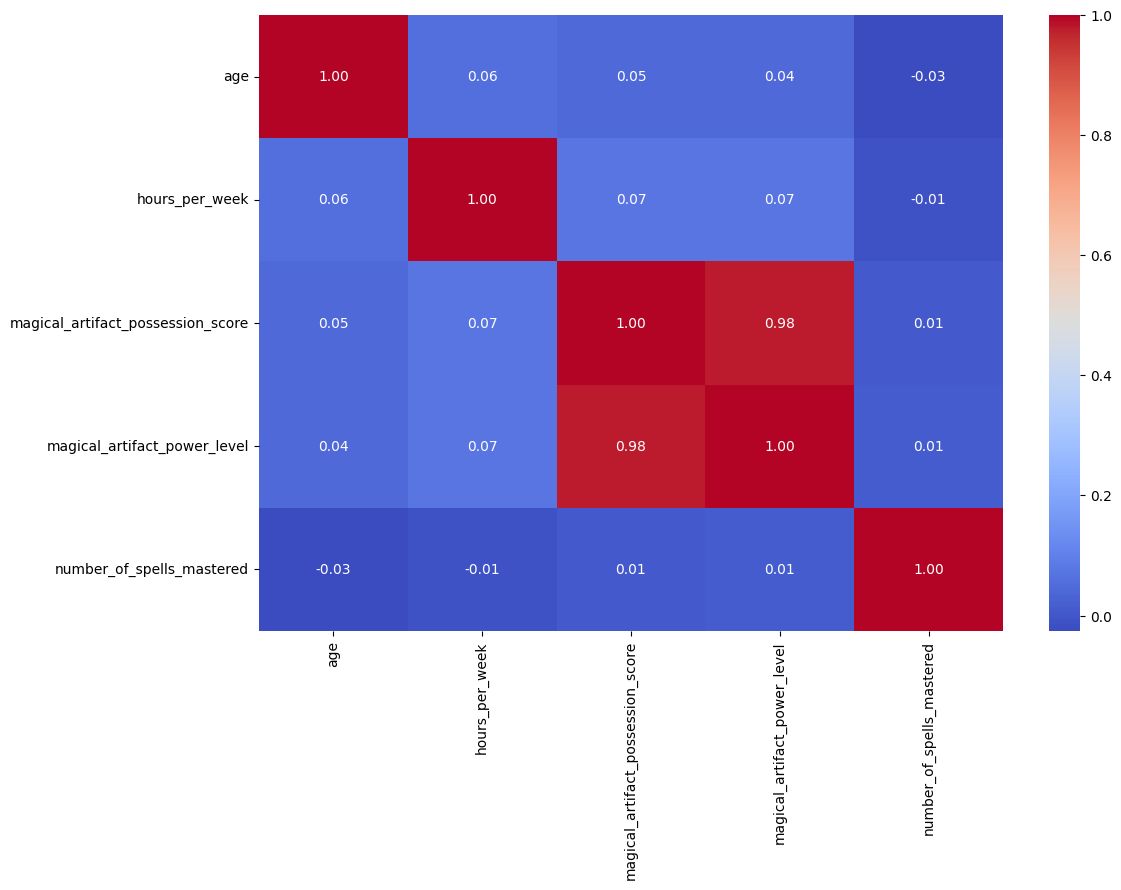

In [ ]:
#There seems to be a strong correlation between magical_artefact_possesion_score and magic_artefact_power_level


#Strong correlations can limit the generalization ability of ML models. Models trained on highly correlated features may fail
#to generalize well to new data because they rely too heavily on the specific relationships observed in the training set.
#This can lead to poor performance when deployed in real-world scenarios.









# Compute the correlation matrix
corr = df[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

# Show the plot
plt.show()

In [ ]:
df = df.drop('magical_artifact_possession_score', axis=1)

Machine learning models that rely on the assumption of independent predictors, such as linear regression models, may be adversely affected by strong correlations between independent variables, often known as multicollinearity. It may result in overfitting and difficult-to-interpret coefficients by making the model unstable.


## b) Deal with extreme outliers

Reflect your answer on 1b). Did you identify any features with extreme outliers?

If yes, explain the nature of these outliers and deal with them appropriately.
- How many are there (in proportion to the whole dataset)?
- would dropping these rows lead to considerable data loss?

Try to also think what could result in the data collection process that resulted in them.

In [ ]:
#A fifth of the data would be lost if we drop those rows and this would lead to considerable data loss
#A betetr way is for example, look at the average of the number of hours worked and put that in instead of leaving the feature blank

df = df[df['number_of_spells_mastered'] >= 0]

## c) Deal with features with missing values

Start by splitting your into training (X_train, y_train) and testing sets (X_test, y_test) in an 80-20 split (hint: use train_test_split from sklearn). Use random_state = 42.

Reflect again on exercise 2c. Did you identify any numerical features with missing values?

- Impute the values in the feature with the missing values using the numerical features.
- Check (e.g. by plotting) the distribution of the feature with the missing values before and after imputation. Ensure that the imputation did not bias/skew the feature's distribution.

Just as a reminder, the dependent variable (y) is gringotts_approved_loan.

`Tip:` It is essential to train the imputation model only on the training data to avoid [data leakage](https://machinelearningmastery.com/data-preparation-without-data-leakage/). Then use the trained imputation model to also predict the most appropriate value for the testing data. Please feel free to use the impute_missing_values function.





Save the imputed dfs as `X_train_imputed` and `X_test_imputed`.



In [ ]:
def impute_missing_values(feature_with_missing, X_train, X_test):
    # One-hot encode categorical features.
    X_train_encoded = pd.get_dummies(X_train)
    X_test_encoded = pd.get_dummies(X_test)

    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='inner', axis=1)

    # Impute using KNN imputer (model-based approach). Importantly, we are only fitting
    # the imputer on the training data.
    knn_imputer_full = KNNImputer(n_neighbors=5)
    X_train_imputed = knn_imputer_full.fit_transform(X_train_encoded)
    X_test_imputed = knn_imputer_full.transform(X_test_encoded)

    # Convert back to pandas DataFrame, ensuring column names are retained.
    X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns, index=X_train_encoded.index)
    X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_encoded.columns, index=X_test_encoded.index)

    # Replace the imputed column to the original X_train and X_test passed in.
    X_train[feature_with_missing] = X_train_imputed[feature_with_missing]
    X_test[feature_with_missing] = X_test_imputed[feature_with_missing]

    return X_train, X_test

In [ ]:
X = df.drop('gringotts_approved_loan', axis=1)
y = df['gringotts_approved_loan']

# Split the dataset into training and testing sets with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the feature with missing values
feature_with_missing = 'hours_per_week'
X_train_imputed, X_test_imputed = impute_missing_values(feature_with_missing, X_train, X_test)

# 4. Train RF model

Train a [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model and evaluate its performance on 10-fold CV and also on the test set. You might find sklearn [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) helpful to create the model (`tip`: use OneHotEncoder to encode the cateogrical features)

Evaluate the performance using accuracy_score and classification_report from sklearn. Comment on the model's performance considering precision and recall. Comment on the generalisability of the model (does it have similar performance on the test set as with the cross validation set?)

Use `X_train_imputed`, `y_train`, `X_test_imputed`, `y_test`.

In [ ]:
# Identify categorical features for OneHotEncoding, assuming they are of type 'object'
categorical_features = X_train_imputed.select_dtypes(include=['object']).columns.tolist()

# Create the preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the column transformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # this means that all other columns not listed will be passed through without transformation
)

# Create the Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model using 10-fold cross-validation
cv = KFold(n_splits=10, random_state=42, shuffle=True)
cv_scores = cross_val_score(rf_pipeline, X_train_imputed, y_train, cv=cv, scoring='accuracy')

print(f'CV Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {np.mean(cv_scores)}')

# Fit the model on the training data
rf_pipeline.fit(X_train_imputed, y_train)

# Predict on the test data
y_pred = rf_pipeline.predict(X_test_imputed)

# Evaluate the model's performance on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {test_accuracy}')

classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

CV Accuracy Scores: [0.8556962  0.8278481  0.83544304 0.86835443 0.86294416 0.84517766
 0.83248731 0.84517766 0.84010152 0.82233503]
Mean CV Accuracy: 0.8435565122405706
Test Set Accuracy: 0.851063829787234
              precision    recall  f1-score   support

          No       0.86      0.90      0.88       601
         Yes       0.83      0.78      0.80       386

    accuracy                           0.85       987
   macro avg       0.85      0.84      0.84       987
weighted avg       0.85      0.85      0.85       987



# 5. Evaluate feature importance
Identify and visualise the top 10 most important features that influence when Gringotts approves a loan.

Comment on the impact of the top few features.

Unique importances: [0.00015592 0.00167623 0.00218402 0.00343803 0.00359036 0.00369338
 0.0037106  0.00374063 0.00448263 0.00485004 0.0050597  0.00506095
 0.00516805 0.00559131 0.00648272 0.00686643 0.00708431 0.00722779
 0.00742767 0.00823506 0.00835271 0.00860504 0.01071027 0.01143118
 0.01331971 0.01466051 0.02045689 0.02505982 0.038937   0.04264917
 0.04488041 0.05609439 0.05646551 0.06282039 0.08306442 0.0857551
 0.08972811 0.09827005 0.1330135 ]
Top indices: [28 37  0 38 35 36 26 31  3 30]


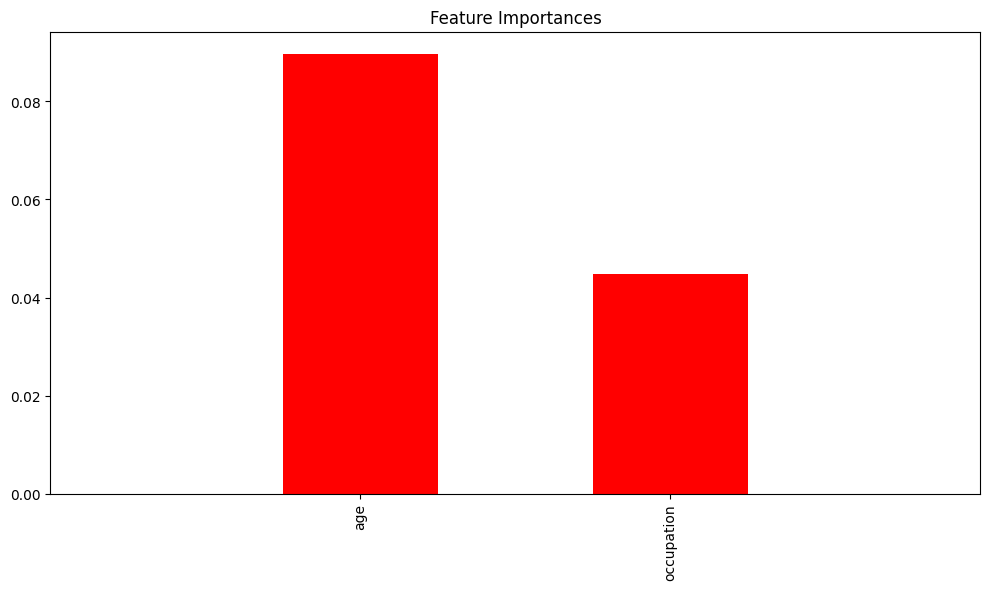

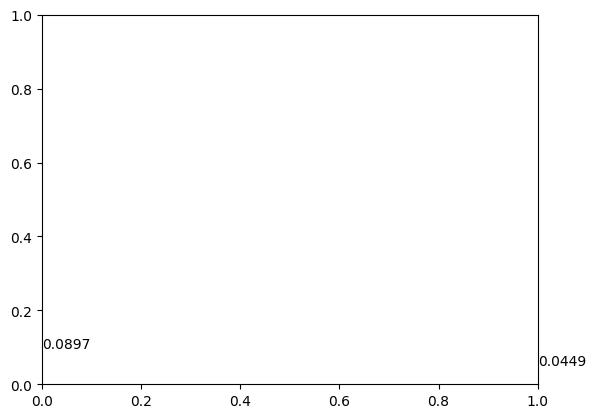

In [ ]:

# Get feature importances from the random forest classifier inside the pipeline
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Check for the number of unique importances
unique_importances = np.unique(importances)
print(f"Unique importances: {unique_importances}")

# If all the importances are the same, the model might not have learned anything useful
# Ensure the model is trained correctly with a proper dataset

# Sort the feature importances in descending order and get the indices of the top 10
indices = np.argsort(importances)[::-1]
top_indices = indices[:10]

# Check that top_indices has 10 unique values
print(f"Top indices: {top_indices}")


# Ensure we only use valid indices to access columns
top_indices = top_indices[top_indices < len(X_train_imputed.columns)]

# Get the feature names based on the indices
feature_names = X_train_imputed.columns[top_indices]

# Plot the feature importances of the top 10 features
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
bars = plt.bar(range(len(top_indices)), importances[top_indices], width=0.5, color="r", align="center")
plt.xticks(range(len(top_indices)), feature_names, rotation=90)
plt.xlim([-1, len(top_indices)])
plt.show()

# Add labels to bars (since we expect 10, this will show if there's an issue)
for bar, imp in zip(bars, importances[top_indices]):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(imp, 4), va='bottom')  # Va='bottom' to put the text at the top of the bar

# 6. Understanding model's performance further

In [ ]:
!pip install fairlearn
from fairlearn.metrics import MetricFrame, selection_rate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 28.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


Determine if the model exhibits bias by performing significantly differently across various groups. For instance, assess whether the model's performance is superior or inferior for samples where the gender is male compared to other groups.

Use the get_fairness_evaluation function to analyze the impact of this and other variables on model performance. This function uses Fairlearn to evaluate how the model fares across different classes, focusing on sensitive metrics such as accuracy, balanced accuracy, precision, and recall.

In [ ]:
def get_fairness_evaluation(X_test, y_test, y_pred, columns):
  sensitive_features_df = X_test[columns]

  def precision_wrapper(y_true, y_pred): return precision_score(y_true, y_pred, pos_label='Yes', zero_division=0)
  def recall_wrapper(y_true, y_pred): return recall_score(y_true, y_pred, pos_label='Yes', zero_division=0)

  mf = MetricFrame(metrics={
                      'accuracy': accuracy_score,
                      'balanced_accuracy': balanced_accuracy_score,
                      'precision': precision_wrapper,
                      'recall': recall_wrapper,
                      'count': lambda y_true, y_pred: y_true.shape[0]},
                  y_true=y_test,
                  y_pred=y_pred,
                  sensitive_features=sensitive_features_df)

  plot = mf.by_group.plot.bar(
    subplots=True,
    legend=True,
    figsize=[12, 8],
    title="Fairness Metrics Across Sensitive Features"
  )

  plt.tight_layout()
  plt.show()

  return mf.by_group

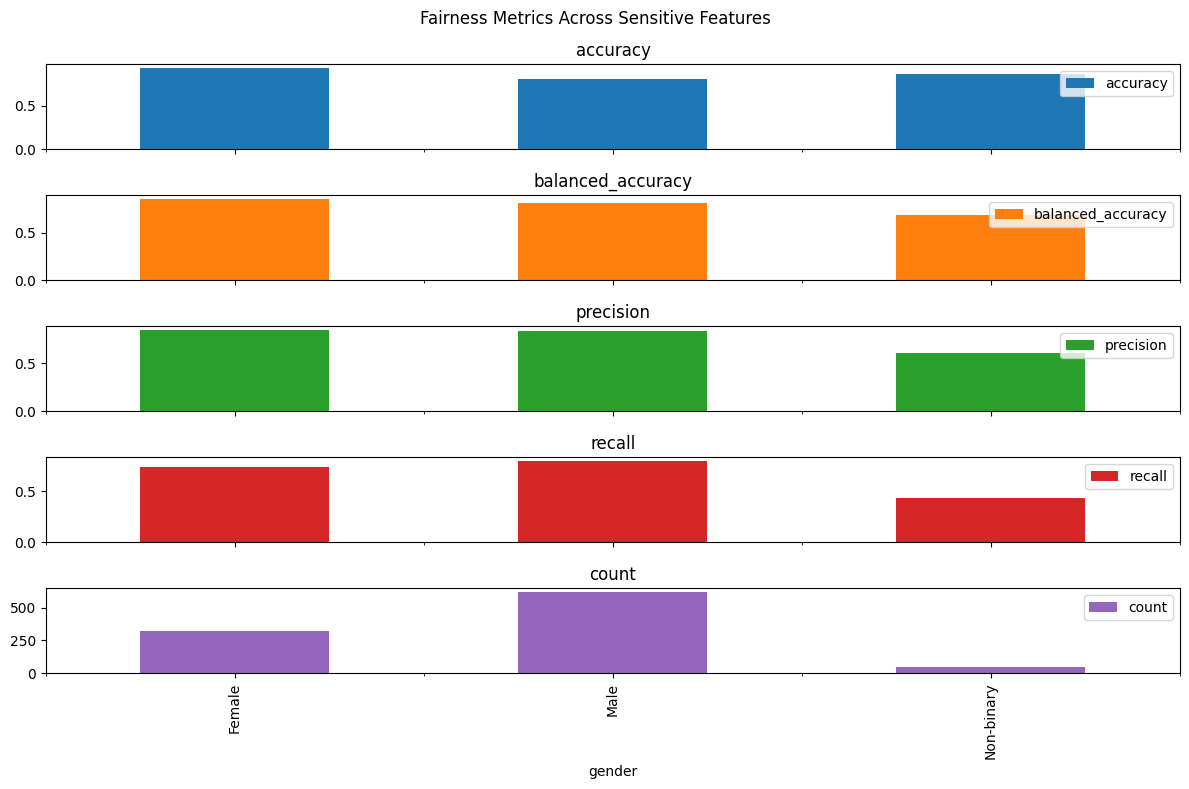

AttributeError: 'Index' object has no attribute '_format_flat'

            accuracy  balanced_accuracy  precision    recall  count
gender                                                             
Female      0.929012           0.853440   0.840000  0.736842  324.0
Male        0.809677           0.810392   0.833333  0.791925  620.0
Non-binary  0.860465           0.686508   0.600000  0.428571   43.0

In [ ]:
get_fairness_evaluation(X_test_imputed, y_test, y_pred, ['gender'])

Try out different combinations. For example you can pass as input to the columns feature ['bloodline', gender'].

# Sociotechnical questions

Reflection questions: As part of the assessment of this bounty you will also be graded on how you reflect on the following questions. When practicing AI Ethics, it is important to understand AI as socio-technical systems, and that although technical issues can be problematic, one need to understand the systematic and social structures giving rise to them in the first place.

- Can all problems with bias be solved technically? If not, why?
- What decision-making systems should be using algorithmic/AI approaches and which should not?
- Is it just and fair to solve problems with bias by fixing technological constraints?

In [ ]:
#No, not every bias issue has a technical solution. Societal, cultural, and historical contexts
#are frequently the source of bias because they are engrained in human decision-making systems and processes.
#While algorithmic modifications, data preprocessing methods, and fairness-aware models are examples of
#technical solutions that can reduce bias, they might not address the underlying causes of bias.
#It takes interdisciplinary approaches that take into account social, legal, and ethical factors in addition to technical ones
#to fully address bias. Furthermore, it is difficult to address biases solely through technical means because
#they can appear at different stages of AI development, from data collection and labelling to model training and deployment.



#Algorithmic and artificial intelligence approaches can be effectively utilised by decision-making systems that involve
#intricate and repetitive tasks, large datasets, and benefit from automation. AI technologies, for example,
#can significantly increase the efficiency and accuracy of fraud detection algorithms, recommendation systems,
#and predictive analytics in the healthcare industry. However, care should be taken when implementing decision-making systems
#that call for human judgement, ethical issues, or high-stakes scenarios. To guarantee fairness, transparency, and the
#upholding of ethical standards, decisions pertaining to, for instance, criminal justice, hiring, and loan
#approvals should involve human oversight and accountability. The use of algorithmic/AI approaches in decision-making
#processes must be carefully considered in terms of its effects, risks, and ethical implications, particularly in
#areas where social justice and human rights are involved.



#Fixing technological limitations alone is not enough to address bias and may not produce equitable and just results.
#It's critical to address technological limitations like skewed datasets, biassed algorithms, and defective model
#architectures, but it's also critical to address the systemic and social factors that underlie bias.
#This entails dealing with problems like institutionalised prejudice, historical injustices, and power disparities that support
#bias in AI systems. Beyond technological fixes, systemic changes are needed to achieve justice and fairness.
#These include addressing broader societal issues of discrimination and inequality, promoting diversity and inclusion
#in AI development teams, and establishing ethical standards and regulations. Community engagement is also crucial.
#Additionally, transparency, accountability, and stakeholder involvement are crucial to ensure that bias mitigation efforts
#are effective, ethical, and aligned with societal values and principles of fairness and justice.





